# Introduction
**Abstract** : In this era of modernization, it becomes difficult to protect the environment from pollution. We need to take an approach that first finds the causing element and then treats it properly. Water is one of the essential elements of day-to-day life. In this Analytical research, we will try to find the top two elements, which are affecting the environment badly, and then we forecast the approximate prediction of those chemicals. We have used the United States Environmental Agency (EPA) real-time dataset and will forecast the water quality for the United States of America.  

## Index

* Introduction 
* Ask Right Questions 
* Importing Libraries
* Dataset
* Data Cleaning
* Data Structuring 
* Analysis
* Conclusion
* References
* Disclaimer

# Importing Libraries

In [ ]:
! pip install pmdarima

In [ ]:
import requests
import csv
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pmdarima.arima import ADFTest, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Dataset
Link - https://www.epa.gov/waterdata/water-quality-data-download#portal

1.   Need to make this data in proper shape. 
2.   Need to save this data in local directory so that we can work easily on it.
3.   Need to reshape it for analysis.

**Water Quality Portal**
The Water Quality Portal (WQP) is a cooperative service sponsored by the United States Geological Survey (USGS), the Environmental Protection Agency (EPA) and the National Water Quality Monitoring Council (NWQMC). It serves over 380 million water result records from EPA STORET/WQX, the USGS National Water Information System (NWIS) and the U.S. Department of Agriculture Sustaining the Earth's Watersheds, Agricultural Research Data System (STEWARDS).

Important Links:
*   https://www.kaggle.com/datajmcn/water-quality-eda-and-potability-analysis
*   https://www.waterqualitydata.us/portal_userguide/

In [ ]:
# Data Set URLs
CSV_URL_USA = "https://www.waterqualitydata.us/data/Result/search?countrycode=US&characteristicType=Radiochemical&startDateLo=01-01-1900&startDateHi=01-01-2021&mimeType=csv&zip=no"

In [ ]:
## Reading USA Dataset. It will take 4 to 5 mins depending upon the dataset size.
with requests.Session() as s:
    download = s.get(CSV_URL_USA)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    df_usa= pd.DataFrame(my_list)

df_usa.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityTypeCode,ActivityMediaName,ActivityMediaSubdivisionName,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,ActivityEndDate,ActivityEndTime/Time,ActivityEndTime/TimeZoneCode,ActivityDepthHeightMeasure/MeasureValue,ActivityDepthHeightMeasure/MeasureUnitCode,ActivityDepthAltitudeReferencePointText,ActivityTopDepthHeightMeasure/MeasureValue,ActivityTopDepthHeightMeasure/MeasureUnitCode,ActivityBottomDepthHeightMeasure/MeasureValue,ActivityBottomDepthHeightMeasure/MeasureUnitCode,ProjectIdentifier,ActivityConductingOrganizationText,MonitoringLocationIdentifier,ActivityCommentText,SampleAquifer,HydrologicCondition,HydrologicEvent,SampleCollectionMethod/MethodIdentifier,SampleCollectionMethod/MethodIdentifierContext,SampleCollectionMethod/MethodName,SampleCollectionEquipmentName,ResultDetectionConditionText,CharacteristicName,ResultSampleFractionText,ResultMeasureValue,ResultMeasure/MeasureUnitCode,MeasureQualifierCode,ResultStatusIdentifier,StatisticalBaseCode,ResultValueTypeName,ResultWeightBasisText,ResultTimeBasisText,ResultTemperatureBasisText,ResultParticleSizeBasisText,PrecisionValue,ResultCommentText,USGSPCode,ResultDepthHeightMeasure/MeasureValue,ResultDepthHeightMeasure/MeasureUnitCode,ResultDepthAltitudeReferencePointText,SubjectTaxonomicName,SampleTissueAnatomyName,ResultAnalyticalMethod/MethodIdentifier,ResultAnalyticalMethod/MethodIdentifierContext,ResultAnalyticalMethod/MethodName,MethodDescriptionText,LaboratoryName,AnalysisStartDate,ResultLaboratoryCommentText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode,PreparationStartDate,ProviderName
1,USGS-NY,USGS New York Water Science Center,nwisny.01.95400104,Sample-Routine,Water,Wet Fall Material,1953-11-01,,,1953-11-30,,,,,,,,,,,,USGS-410048073544800,,,Not determined,Routine sample,USGS,USGS,USGS,Unknown,,Tritium,,7.3,T.U.,,Historical,,Estimated,,,,,,,07012,,,,,,,,,,,,,,,,,NWIS
2,USGS-NY,USGS New York Water Science Center,nwisny.01.95400114,Sample-Routine,Water,Wet Fall Material,1954-03-01,,,1954-03-31,,,,,,,,,,,,USGS-410048073544800,,,Not determined,Routine sample,USGS,USGS,USGS,Unknown,,Tritium,,157,T.U.,,Historical,,Estimated,,,,,,,07012,,,,,,,,,,,,,,,,,NWIS
3,USGS-IL,USGS Illinois Water Science Center,nwisil.01.95300012,Sample-Routine,Water,Wet Fall Material,1953-02-01,,,1953-02-28,,,,,,,,,,,,USGS-414700087350000,,,Not determined,Routine sample,USGS,USGS,USGS,Unknown,,Tritium,,4.6,T.U.,,Historical,,Estimated,,,,,,,07012,,,,,,,,,,,,,,,,,NWIS
4,USGS-NJ,USGS New Jersey Water Science Center,nwisnj.01.91800002,Sample-Routine,Water,Surface Water,1918-06-08,10:00:00,EDT,,,,,,,,,,,,U.S. Geological Survey-Water Resources Discipline,USGS-01443500,,,Not determined,Routine sample,USGS,USGS,USGS,Unknown,,Potassium-40,Dissolved,0.90,pCi/L,,Historical,,Actual,,,,,,,82068,,,,,,,,,,,,,,,,,NWIS


# Data Cleaning

In [ ]:
# Save the copy for re-use instead of downloading again and again
dfOriginal = df_usa.copy()

In [ ]:
# Run from this cell if you want to restart the analysis
df = dfOriginal

In [ ]:
rows, columns = df.shape
print("Total Rows: {}\nTotal Columns: {}".format(str(rows),str(columns)))

Total Rows: 823997
Total Columns: 63


In [ ]:
# Beautify the Data
new_header = df.iloc[0] 
df = df[1:] 
df.columns = new_header

In [ ]:
df.describe()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityTypeCode,ActivityMediaName,ActivityMediaSubdivisionName,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,ActivityEndDate,ActivityEndTime/Time,ActivityEndTime/TimeZoneCode,ActivityDepthHeightMeasure/MeasureValue,ActivityDepthHeightMeasure/MeasureUnitCode,ActivityDepthAltitudeReferencePointText,ActivityTopDepthHeightMeasure/MeasureValue,ActivityTopDepthHeightMeasure/MeasureUnitCode,ActivityBottomDepthHeightMeasure/MeasureValue,ActivityBottomDepthHeightMeasure/MeasureUnitCode,ProjectIdentifier,ActivityConductingOrganizationText,MonitoringLocationIdentifier,ActivityCommentText,SampleAquifer,HydrologicCondition,HydrologicEvent,SampleCollectionMethod/MethodIdentifier,SampleCollectionMethod/MethodIdentifierContext,SampleCollectionMethod/MethodName,SampleCollectionEquipmentName,ResultDetectionConditionText,CharacteristicName,ResultSampleFractionText,ResultMeasureValue,ResultMeasure/MeasureUnitCode,MeasureQualifierCode,ResultStatusIdentifier,StatisticalBaseCode,ResultValueTypeName,ResultWeightBasisText,ResultTimeBasisText,ResultTemperatureBasisText,ResultParticleSizeBasisText,PrecisionValue,ResultCommentText,USGSPCode,ResultDepthHeightMeasure/MeasureValue,ResultDepthHeightMeasure/MeasureUnitCode,ResultDepthAltitudeReferencePointText,SubjectTaxonomicName,SampleTissueAnatomyName,ResultAnalyticalMethod/MethodIdentifier,ResultAnalyticalMethod/MethodIdentifierContext,ResultAnalyticalMethod/MethodName,MethodDescriptionText,LaboratoryName,AnalysisStartDate,ResultLaboratoryCommentText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode,PreparationStartDate,ProviderName
count,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996,823996
unique,161,154,298971,31,8,37,16796,1728,20,2262,1514,11,2207,5,12,1978,8,2225,8,671,167,106860,47813,936,9,20,270,118,243,116,14,108,23,23509,29,19,5,8,4,3,5,2,20,3830,12976,405,59,2,2,120,25,522,52,467,64,213,8349,125,32,4263,23,735,2
top,11NPSWRD_WQX,National Park Service Water Resources Division,21IOWA-SAMP-WAT-GWM-2004-0,Sample-Routine,Water,Groundwater,1978-07-10,,MDT,,,,,,,,,,,,U.S. Geological Survey-Water Resources Discipline,USGS-433013113024201,,,,Routine sample,USGS,USGS,USGS,Unknown,,Uranium,Dissolved,,pCi/L,,Historical,,Actual,,,,,,,,,,,,,,USGS,,,,,,,,,,NWIS
freq,93534,93534,510,671811,703157,377475,1615,85541,177792,803349,813445,811804,745501,745501,766216,772940,772940,769269,769269,478961,447434,2238,610644,738620,254851,399494,430157,430157,430157,455517,693182,186747,358128,130777,395327,809238,297551,707021,815436,740653,794787,823988,806652,718825,742889,254851,823627,823627,823577,821730,821727,245150,331477,271768,623785,480475,482154,780012,594068,584492,583776,814982,569145


In [ ]:
important_columns = ['OrganizationIdentifier',	'OrganizationFormalName',	'ActivityMediaName',	'ActivityMediaSubdivisionName',	'ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode', 'ActivityEndDate', 'ActivityEndTime/Time', 'CharacteristicName', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'ResultStatusIdentifier']
dataset = df[important_columns]
dataset.head()
print(dataset.shape)

(823996, 13)


In [ ]:
# Change column name to readable column names
dataset.columns = ['Organization_Identifier',	
                   'Organization_Formal_Name',	
                   'Activity_Media_Name',	
                   'Activity_Media_Subdivision_Name',	
                   'Activity_Start_Date', 
                   'Activity_Start_Time', 
                   'Activity_StartT_TimeZone_Code', 
                   'Activity_EndDate', 
                   'Activity_EndTime', 
                   'Characteristic_Name', 
                   'Result_Measure_Value', 
                   'Result_Measure_Unit_Code', 
                   'Result_Status_Identifier']

## Handle 'Null' Values

In [ ]:
# fill the blank cells
dataset = dataset.replace(r'^\s*$', np.nan, regex=True)
print("Blank Filled Done !!")

Blank Filled Done !!


In [ ]:
dataset.isnull().sum()

Organization_Identifier                 0
Organization_Formal_Name                0
Activity_Media_Name                   113
Activity_Media_Subdivision_Name    184764
Activity_Start_Date                     0
Activity_Start_Time                 85541
Activity_StartT_TimeZone_Code       94549
Activity_EndDate                   803349
Activity_EndTime                   813445
Characteristic_Name                     0
Result_Measure_Value               130777
Result_Measure_Unit_Code           104971
Result_Status_Identifier                0
dtype: int64

# Data Structuring

Starting with Most important column {Relation wrt. Characteristic_Name}

1.   Result_Measure_Unit_Code
2.   Result_Measure_Value


Note:- pCi/L to pCi/g -> 1 pCi/L = 0.001356 pCi/g
```
1 pCi/L =  1.3564 pCi/kg 
1.3564 pCi/kg / 1000 = 0.001356 pCi/g
```
pCi/L to ug/L -> 1 pCi/L = 0.6666 ug/L

Radioactivity refers to the amount of ionizing radiation released by a material. Whether it emits alpha or beta particles, gamma rays, x-rays, or neutrons, a quantity of radioactive material is expressed in terms of its radioactivity (or simply its activity). This represents how many atoms in the material decay in a given time period. The units of measurement for radioactivity are the becquerel (Bq, international unit) and the curie (Ci, U.S. unit).
https://ehs.ucmerced.edu/sites/ehs.ucmerced.edu/files/documents/radiation-safety/appendixd-conversion_factors.pdf 
http://www.radprocalculator.com/Conversion.aspx 

  



In [ ]:
temp = dataset.groupby('Characteristic_Name')['Result_Measure_Unit_Code'].unique()
print(temp)

Characteristic_Name
Actinium-228                                   [nan, pCi/L, pCi/g]
Alpha emitting radium isotopes                        [pCi/L, nan]
Alpha particle                    [pCi/L, ug/l, nan, pCi/g, mg/kg]
Americium-241                                  [nan, pCi/L, pCi/g]
Anthanthrene                              [nan, ng/g, ng/l, ug/kg]
                                                ...               
Xenon-136                                             [cm3/g @STP]
Ytterbium-169                                         [pCi/L, nan]
Zinc-65                                               [nan, pCi/L]
Zirconium-95                                          [nan, pCi/L]
Zirconium/Niobium-95                                       [pCi/L]
Name: Result_Measure_Unit_Code, Length: 108, dtype: object


In [ ]:
unique_measure_unit_code = set()
value_count_for_each = {}
for val in temp.items():
  for i in val[1]:
    if i not in value_count_for_each.keys():
      value_count_for_each[i] = []
    value_count_for_each[i].append(str(val[0]))
  unique_measure_unit_code = unique_measure_unit_code.union(set(val[1]))

print(unique_measure_unit_code)
print(value_count_for_each)
print( { key : len(value_count_for_each[key]) for key in value_count_for_each.keys() })

{nan, 'ug/L U3O8', 'lb/day', 'mg/kg', 'mg/l', 'ng/l', 'ug/kg', 'pmc', 'ppb', 'TU', 'years', 'pCi/L', 'None', 'ug/l', 'mCi/km2', 'dpm/g', 'ng/g', 'ratio', 'pCi/ml', 'count', 'bq/g', 'pct modern', 'pCi/g', 'ug/g', 'ppm', 'cm3/g @STP', 'dpm/100l', '%', 'T.U.'}
{nan: ['Actinium-228', 'Alpha emitting radium isotopes', 'Alpha particle', 'Americium-241', 'Anthanthrene', 'Antimony-125', 'Barium-140', 'Beryllium-7', 'Beta particle', 'Bismuth-212', 'Bismuth-214', 'Calcium-45', 'Carbon-14', 'Cerium-141', 'Cerium-144', 'Cesium-134', 'Cesium-136', 'Cesium-137', 'Cobalt-57', 'Cobalt-58', 'Cobalt-60', 'Europium-152', 'Europium-154', 'Gamma radiation', 'Gross alpha radioactivity, (Americium-241 ref std)', 'Gross alpha radioactivity, (Thorium-230 ref std)', 'Gross alpha radioactivity, (nat-Uranium ref std)', 'Gross beta radioactivity, (Cesium-137 ref std)', 'Gross beta radioactivity, (Strontium-Yttrium-90 ref std)', 'Indium-111', 'Iodine-123', 'Iodine-129', 'Iodine-131', 'Iodine-132', 'Iodine-133', 'Ir

In [ ]:
# Convert Procalcitonin (PCT) level is itself is  µg/L, Hence i will just make pct modern ug/l
ableToConvert = {
  'pCi/L' : 1,
  'pCi/ml' : 100,
  'pCi/g' : 100,
  'ug/l' : 1.48,
  'ug/g' : 148,
  'ug/kg' : 148000,
  'mg/kg' : 1.5,
  'mg/l' : 0.0015,
  'ng/l' : 0.0000000015,
  'ng/g' : 0.148,
  'dpm/100l' : 0.0222,
  'dpm/g' : 0.000222,
  'bq/g' : 3.7,
  'T.U.' : 3,
  'pct modern': 1.48}
notAbleToConvert = ['cm3/g @STP', 'pmc', 'lb/day', 'count', '%', 'years']
notAbleToConvertdataset = dataset[dataset['Result_Measure_Unit_Code'].isin(notAbleToConvert)]
print(notAbleToConvertdataset.count())

Organization_Identifier            60
Organization_Formal_Name           60
Activity_Media_Name                60
Activity_Media_Subdivision_Name    45
Activity_Start_Date                60
Activity_Start_Time                60
Activity_StartT_TimeZone_Code      57
Activity_EndDate                    6
Activity_EndTime                    6
Characteristic_Name                60
Result_Measure_Value               60
Result_Measure_Unit_Code           60
Result_Status_Identifier           60
dtype: int64


In [ ]:
grouped_df = notAbleToConvertdataset.groupby(['Characteristic_Name', 'Result_Measure_Unit_Code']).size()
print(grouped_df)

Characteristic_Name  Result_Measure_Unit_Code
Carbon-14            %                           19
                     pmc                          4
                     years                        4
Krypton-78           cm3/g @STP                   7
Radium-226           %                            2
Radium-228           %                            2
Uranium              %                            2
                     count                        3
                     lb/day                       1
Xenon-124            cm3/g @STP                   8
Xenon-136            cm3/g @STP                   8
dtype: int64


In [ ]:
def extract_number(s):
  try:
    temp = [float(s) for s in re.findall(r'-?\d+\.?\d*', s)][0]
    return temp
  except: 
    # print("Unexpected error: for value {}".format(s)) 
    raise 


def is_number(s):
    try:
        extract_number(s)
        return True
    except:
        return False

In [ ]:
# Make all the NaN to '', So that strip the values easily
dataset['Result_Measure_Unit_Code'] = dataset['Result_Measure_Unit_Code'].fillna('')
dataset['Result_Measure_Unit_Code'] = dataset['Result_Measure_Unit_Code'].apply(lambda x: x.strip())

In [ ]:
#Convert the Result_Measure_Value to all pCi/L
converted = 0
notConverted = 0
for index, row in dataset.iterrows():
    if(row['Result_Measure_Unit_Code'] in ableToConvert.keys() and is_number(row['Result_Measure_Value'])):
      converted += 1
      multipler = ableToConvert[row['Result_Measure_Unit_Code']]
      row['Result_Measure_Value']  = float(multipler) * extract_number(row['Result_Measure_Value'])
      row['Result_Measure_Unit_Code'] = 'pCi/L'
    else:
      # print(row['Result_Measure_Unit_Code'], row['Result_Measure_Value'])
      notConverted += 1
grouped_df = dataset.groupby(['Result_Measure_Unit_Code']).size()
print(grouped_df)
print("How many records converted: {} and not converted: {}".format(str(converted),str(notConverted)))

# Only use pCi/L values
dataset = dataset[dataset['Result_Measure_Unit_Code']=='pCi/L']

Result_Measure_Unit_Code
              104971
%                 25
None               4
T.U.               7
TU               184
cm3/g @STP        23
count              3
lb/day             1
mCi/km2           10
mg/kg             70
mg/l             579
ng/g             167
ng/l              46
pCi/L         622842
pCi/g            181
pCi/ml            10
pmc                4
ppb            28063
ppm            62386
ratio             42
ug/L U3O8         15
ug/g              18
ug/l            4341
years              4
dtype: int64
How many records converted: 616365 and not converted: 207631


In [ ]:
# Now just Drop NaN for columns Activity_Media_Name
rowsO, columnsO = dataset.shape
dataset = dataset.dropna(subset=['Activity_Media_Name', 'Result_Measure_Value'])
rowsD, columnsD = dataset.shape
print("Total Rows: {}\nTotal Columns: {}".format(str(rowsD),str(columnsD)))
print("Total Rows Droped: {}".format(str(rowsO - rowsD)))

Total Rows: 616355
Total Columns: 13
Total Rows Droped: 6487


In [ ]:
#Now find again null
dataset = dataset.replace(r'^\s*$', np.nan, regex=True)
print("Blank Filled Done !!")
print("Final Shape of Dataset Rows: {} and Columns: {}".format(str(dataset.shape[0]), str(dataset.shape[1])))
dataset.isnull().sum()

Blank Filled Done !!
Final Shape of Dataset Rows: 616355 and Columns: 13


Organization_Identifier                 0
Organization_Formal_Name                0
Activity_Media_Name                     0
Activity_Media_Subdivision_Name     70431
Activity_Start_Date                     0
Activity_Start_Time                 60718
Activity_StartT_TimeZone_Code       65948
Activity_EndDate                   597834
Activity_EndTime                   607902
Characteristic_Name                     0
Result_Measure_Value                    0
Result_Measure_Unit_Code                0
Result_Status_Identifier                0
dtype: int64

In [ ]:
dataset = dataset[~dataset['Result_Measure_Value'].isin(['non detect', 'Not Detected'])] 

## Find the Outliers 

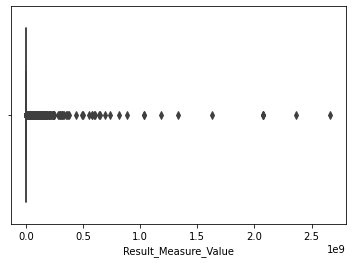

In [ ]:
sns.boxplot(x=dataset['Result_Measure_Value'])

In [ ]:
Q1 = dataset['Result_Measure_Value'].quantile(0.25)
Q3 = dataset['Result_Measure_Value'].quantile(0.75)
IQR = Q3 - Q1
print("IQR: "+str(IQR))
print("Before Outliers Rows: {} and Columns: {}".format(str(dataset.shape[0]), str(dataset.shape[1])))
datasetTemp = dataset[~((dataset['Result_Measure_Value'] < (Q1 - 1.5 * IQR)) | (dataset['Result_Measure_Value'] > (Q3 + 1.5 * IQR)))]
print("Before Outliers Rows: {} and Columns: {}".format(str(datasetTemp.shape[0]), str(datasetTemp.shape[1])))
print("Outliers found: {}".format(str(dataset.shape[0] - datasetTemp.shape[0])))
dataset = datasetTemp.copy()

IQR: 19.42
Before Outliers Rows: 616294 and Columns: 13
Before Outliers Rows: 506662 and Columns: 13
Outliers found: 109632


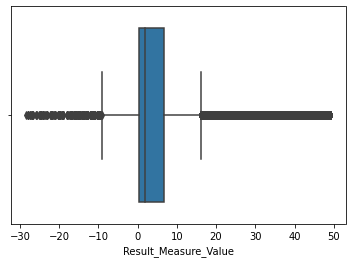

In [ ]:
sns.boxplot(x=dataset['Result_Measure_Value'])

## Save the Data (Optional)

In [ ]:
dataset.to_csv('Dataset_US_2000_to_2020.csv')
print("Dataset has been saved!!!")

Dataset has been saved!!!


# Analysis

## Which is the top 2 radiant found from the year 2000 to 2021? 

In [ ]:
dfUS = dataset
ChemicalFound = dfUS['Characteristic_Name'].unique()
print("Min. Date: {0} , Max. Date: {1}".format(str(dfUS['Activity_Start_Date'].min()), str(dfUS['Activity_Start_Date'].max())))
total_records = 0
for y in range(2000,2021):
  tempYear = dfUS[pd.DatetimeIndex(dfUS['Activity_Start_Date']).year == y]
  print("Year {} the Dataset Rows are: {}".format(y, tempYear.shape[0]))
  total_records += tempYear.shape[0]

print("Total Records: {}".format(total_records))

Min. Date: 1900-05-12 , Max. Date: 2020-12-30
Year 2000 the Dataset Rows are: 13419
Year 2001 the Dataset Rows are: 13052
Year 2002 the Dataset Rows are: 11522
Year 2003 the Dataset Rows are: 10978
Year 2004 the Dataset Rows are: 10371
Year 2005 the Dataset Rows are: 11060
Year 2006 the Dataset Rows are: 11411
Year 2007 the Dataset Rows are: 12548
Year 2008 the Dataset Rows are: 9996
Year 2009 the Dataset Rows are: 9826
Year 2010 the Dataset Rows are: 10684
Year 2011 the Dataset Rows are: 14003
Year 2012 the Dataset Rows are: 13962
Year 2013 the Dataset Rows are: 16073
Year 2014 the Dataset Rows are: 16644
Year 2015 the Dataset Rows are: 17205
Year 2016 the Dataset Rows are: 17166
Year 2017 the Dataset Rows are: 13936
Year 2018 the Dataset Rows are: 12606
Year 2019 the Dataset Rows are: 10359
Year 2020 the Dataset Rows are: 4824
Total Records: 261645


In [ ]:
pd.options.mode.chained_assignment = None 
dfUSProcessed = pd.DataFrame(columns = ['Year', 'Characteristic_Name', 'Mean_Result_Measure_Value'])
for y in range(2000,2021):
  dfTemp = pd.DataFrame(columns = ['Year', 'Characteristic_Name', 'Mean_Result_Measure_Value'], )
  tempYear = dfUS[pd.DatetimeIndex(dfUS['Activity_Start_Date']).year == y]
  temp = tempYear['Result_Measure_Value'].astype(float)
  tempYear['Result_Measure_Value'] = temp
  seriesTemp = tempYear.groupby(['Characteristic_Name']).mean().sort_values('Result_Measure_Value')
  print(y)
  dfTemp['Characteristic_Name'] = seriesTemp.index
  dfTemp['Mean_Result_Measure_Value'] = seriesTemp.values
  dfTemp['Year'] = y
  print(dfTemp)
  dfUSProcessed = dfUSProcessed.append(dfTemp)
  print("Year {} the Dataset Rows are: {}".format(y, tempYear.shape[0]))

2000
    Year  ... Mean_Result_Measure_Value
0   2000  ...                 -0.015455
1   2000  ...                  0.023710
2   2000  ...                  0.032912
3   2000  ...                  0.043333
4   2000  ...                  0.146400
5   2000  ...                  0.157290
6   2000  ...                  0.525843
7   2000  ...                  0.734592
8   2000  ...                  0.943030
9   2000  ...                  1.257552
10  2000  ...                  1.803748
11  2000  ...                  1.858333
12  2000  ...                  2.268121
13  2000  ...                  2.316742
14  2000  ...                  3.751537
15  2000  ...                  3.887500
16  2000  ...                  4.007459
17  2000  ...                  4.488474
18  2000  ...                  4.654265
19  2000  ...                  5.394904
20  2000  ...                  5.568145
21  2000  ...                  6.119507
22  2000  ...                  6.160234
23  2000  ...                  6.87

In [ ]:
dfUSProcessed[dfUSProcessed['Mean_Result_Measure_Value'].isin(dfUSProcessed['Mean_Result_Measure_Value'].nlargest(n=5))]

,Year,Characteristic_Name,Mean_Result_Measure_Value
45,2000,Thorium-234,48.800000
45,2001,Thorium-234,46.111111
36,2003,Bismuth-212,42.933333
46,2004,Actinium-228,41.800000
48,2006,Thorium-228,48.000000


In [ ]:
dfUSProcessedTop5 = pd.DataFrame()
for y in range(2000,2021):
  dfTemp = dfUSProcessed[dfUSProcessed['Year'] == y]
  tempData = dfTemp[dfTemp['Mean_Result_Measure_Value'].isin(dfTemp['Mean_Result_Measure_Value'].nlargest(n=5))]
  dfUSProcessedTop5 = dfUSProcessedTop5.append(tempData)

dfUSProcessedTop5

,Year,Characteristic_Name,Mean_Result_Measure_Value
41,2000,Radium-223,26.606000
42,2000,Bismuth-212,29.500000
43,2000,Radon-219,39.600000
44,2000,Potassium-40,40.033333
45,2000,Thorium-234,48.800000
...,...,...,...
17,2020,Uranium-234,8.051957
18,2020,"Gross beta radioactivity, (Strontium-Yttrium-9...",9.834844
19,2020,"Gross alpha radioactivity, (Thorium-230 ref std)",16.458031
20,2020,"Gross alpha radioactivity, (nat-Uranium ref std)",17.500000


### Interactive Bar Plot

In [ ]:
fig = px.histogram(dfUSProcessedTop5, 
            x = "Characteristic_Name",
             color = 'Year',
             )
fig.update_xaxes(categoryorder="total descending")
fig.show()

**Answer : [Radon-222 and Bismuth-214]**

## How will the Radon-222 and Bismuth-214 grow in coming years? 

In [ ]:
dataset["Characteristic_Name"] = dataset["Characteristic_Name"].str.strip()
radondf = dataset[dataset["Characteristic_Name"] =='Radon-222'][['Activity_Start_Date','Characteristic_Name','Result_Measure_Value']]
bismuthdf = dataset[dataset["Characteristic_Name"]=='Bismuth-214'][['Activity_Start_Date','Characteristic_Name','Result_Measure_Value']]
leaddf = dataset[dataset["Characteristic_Name"]=='Lead-214'][['Activity_Start_Date','Characteristic_Name','Result_Measure_Value']]
print(radondf.shape)
print(bismuthdf.shape)
print(leaddf.shape)

(13271, 3)
(469, 3)
(379, 3)


[Text(0, 0.5, 'Result_Measure_Value'),
 Text(0.5, 0, 'Activity_Start_Date'),
 Text(0.5, 1.0, 'Value of Radon-222 Result_Measure_Value')]

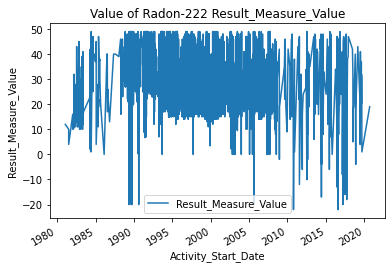

In [ ]:
radondf['Activity_Start_Date'] = pd.to_datetime(radondf['Activity_Start_Date'], errors='coerce')
radondf['Result_Measure_Value'] = pd.to_numeric(radondf['Result_Measure_Value'])
radondf = radondf.set_index('Activity_Start_Date')
ax = radondf.plot()
ax.set(title='Value of Radon-222 Result_Measure_Value', ylabel='Result_Measure_Value', xlabel='Activity_Start_Date')

[Text(0, 0.5, 'Result_Measure_Value'),
 Text(0.5, 0, 'Activity_Start_Date'),
 Text(0.5, 1.0, 'Value of Bismuth Result_Measure_Value')]

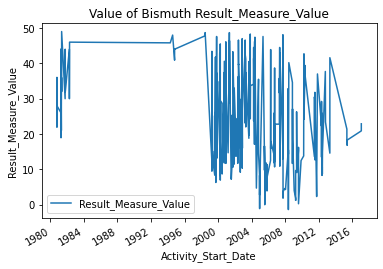

In [ ]:
bismuthdf['Activity_Start_Date'] = pd.to_datetime(bismuthdf['Activity_Start_Date'], errors='coerce')
bismuthdf['Result_Measure_Value'] = pd.to_numeric(bismuthdf['Result_Measure_Value'])
bismuthdf = bismuthdf.set_index('Activity_Start_Date')
ax = bismuthdf.plot()
ax.set(title='Value of Bismuth Result_Measure_Value', ylabel='Result_Measure_Value', xlabel='Activity_Start_Date')

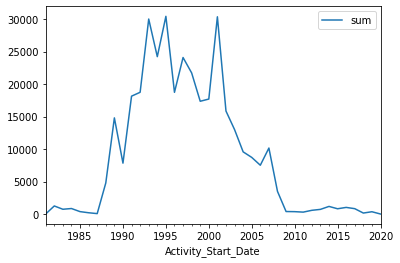

In [ ]:
yearly_summary_radon = radondf['Result_Measure_Value'].resample('y').agg(['sum'])
yearly_summary_radon.plot()

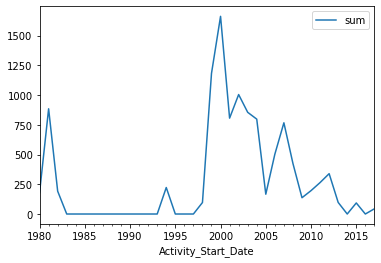

In [ ]:
yearly_summary_bismuth = bismuthdf['Result_Measure_Value'].resample('y').agg(['sum'])
yearly_summary_bismuth.plot()

### Check Stationarity

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



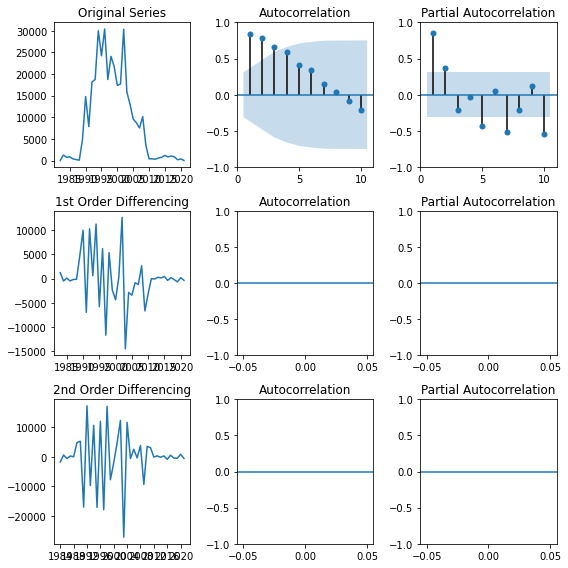

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 3, figsize=(8,8))
axes[0, 0].plot(yearly_summary_radon); axes[0, 0].set_title('Original Series')
plot_acf(yearly_summary_radon,  lags=10, zero=False, ax=axes[0, 1])
plot_pacf(yearly_summary_radon,  lags=10, zero=False, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(yearly_summary_radon.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(yearly_summary_radon.diff(),  lags=10, zero=False, ax=axes[1, 1])
plot_pacf(yearly_summary_radon.diff(),  lags=10, zero=False, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(yearly_summary_radon.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(yearly_summary_radon.diff().diff(),  lags=10, zero=False, ax=axes[2, 1])
plot_pacf(yearly_summary_radon.diff().diff(),  lags=10, zero=False, ax=axes[2, 2])

fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



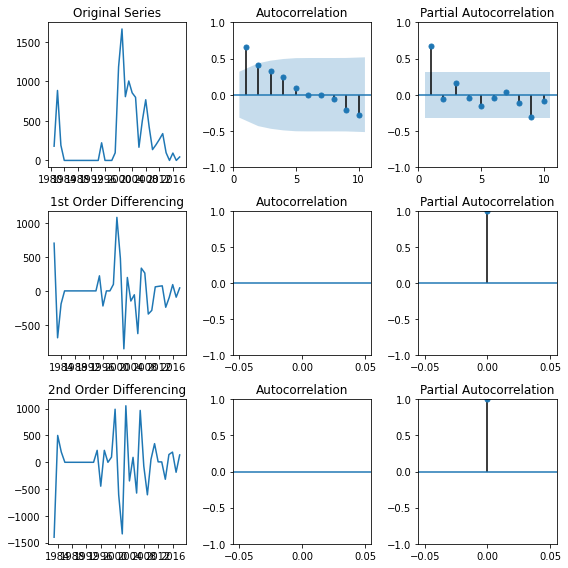

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 3, figsize=(8,8))
axes[0, 0].plot(yearly_summary_bismuth); axes[0, 0].set_title('Original Series')
plot_acf(yearly_summary_bismuth,  lags=10, zero=False, ax=axes[0, 1])
plot_pacf(yearly_summary_bismuth,  lags=10, zero=False, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(yearly_summary_bismuth.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(yearly_summary_bismuth.diff(),  lags=10, ax=axes[1, 1])
plot_pacf(yearly_summary_bismuth.diff(),  lags=10, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(yearly_summary_bismuth.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(yearly_summary_bismuth.diff().diff(),  lags=10, ax=axes[2, 1])
plot_pacf(yearly_summary_bismuth.diff().diff(),  lags=10, ax=axes[2, 2])

fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



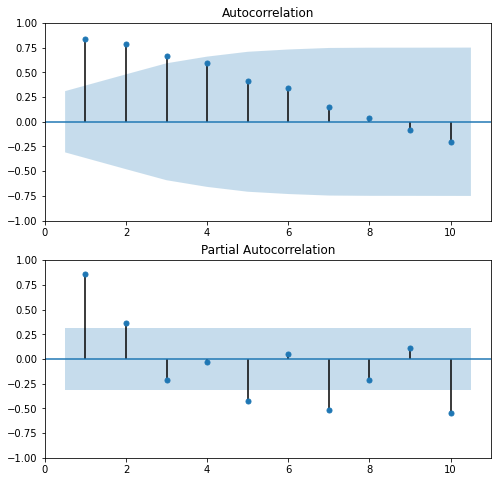

In [ ]:
# ACF and PACF for Radon Values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(yearly_summary_radon, lags=10, zero=False, ax=ax1)
plot_pacf(yearly_summary_radon, lags=10, zero=False, ax=ax2)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



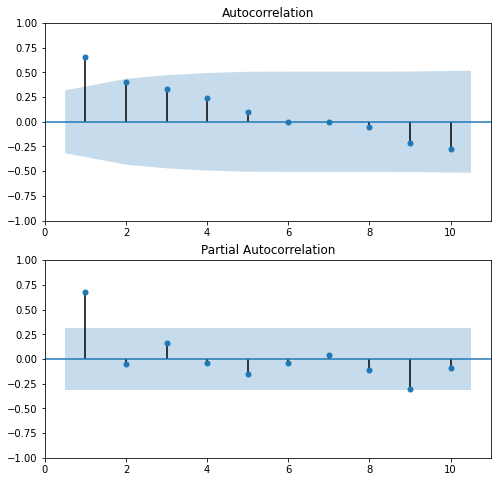

In [ ]:
# ACF and PACF for Bismuth Values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(yearly_summary_bismuth, lags=10, zero=False, ax=ax1)
plot_pacf(yearly_summary_bismuth, lags=10, zero=False, ax=ax2)
plt.show()

### Test the Stationarity

In [ ]:
# ADF Test
result = adfuller(yearly_summary_radon, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -2.0854743833586933
n_lags: 0.25039539523373744
p-value: 0.25039539523373744
Critial Values:
   1%, -3.6461350877925254
Critial Values:
   5%, -2.954126991123355
Critial Values:
   10%, -2.6159676124885216


In [ ]:
# ADF Test
result = adfuller(yearly_summary_bismuth, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -2.6346987858049764
n_lags: 0.08603567172036286
p-value: 0.08603567172036286
Critial Values:
   1%, -3.6209175221605827
Critial Values:
   5%, -2.9435394610388332
Critial Values:
   10%, -2.6104002410518627


### Apply Auto Arima and Forcast

In [ ]:
arima_modal = auto_arima(yearly_summary_radon, 
                         start_p=1, d=0, start_q=1, 
                         max_p=5, max_d=2, max_q=5, 
                         start_P=1, D=0, start_Q=1, 
                         max_P=3, max_D=2, max_Q=3, 
                         max_order=10, m=0, 
                         seasonal=False, stationary=True,
                         test='adf', 
                         error_action='warn', trace=False, random=False, 
                         random_state=20, n_fits=10, return_valid_fits=False, stepwise=True)

In [ ]:
arima_modal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -395.715
Date:                Sat, 16 Oct 2021   AIC                            799.431
Time:                        05:52:09   BIC                            806.186
Sample:                             0   HQIC                           801.873
                                 - 40                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0178      0.137      0.130      0.897      -0.250       0.286
ar.L2          0.8466      0.101      8.383      0.000       0.649       1.045
ma.L1          0.7277      0.193      3.775      0.000       0.350       1.105
sigma2       2.51e+07   4.72e-09   5.32e+15      0.000    2.51e+07    2.51e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 3.34
Prob(Q):                              0.73   Prob(JB):                         0.19
Heteroskedasticity (H):               0.13   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.22e+31. Standard errors may be unstable.
"""

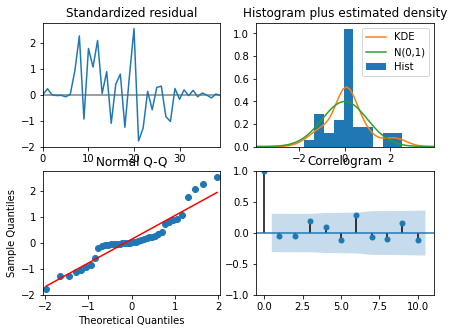

In [ ]:
arima_modal.plot_diagnostics(figsize=(7,5))
plt.show()

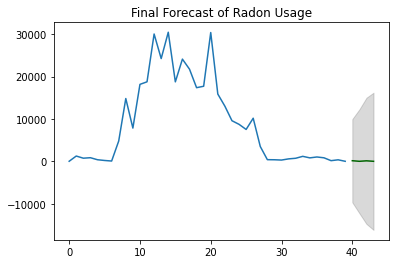

In [ ]:
# Forecast
n_periods = 4
fc, confint = arima_modal.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(yearly_summary_radon.values), len(yearly_summary_radon.values)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(yearly_summary_radon.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Radon Usage")
plt.show()

In [ ]:
prediction = pd.DataFrame(arima_modal.predict(n_period=20), columns = ['Predicted Value'])
prediction

,Predicted Value
0,152.619085
1,18.799132
2,129.544641
3,18.218843
4,109.999031
5,17.380066
6,93.436408
7,16.375481
8,79.396295
9,15.275366


In [ ]:
arima_modal = auto_arima(yearly_summary_bismuth, 
                         start_p=1, d=0, start_q=1, 
                         max_p=5, max_d=2, max_q=5, 
                         start_P=1, D=0, start_Q=1, 
                         max_P=3, max_D=2, max_Q=3, 
                         max_order=10, m=0, 
                         seasonal=False, stationary=True,
                         test='adf', 
                         error_action='warn', trace=False, random=False, 
                         random_state=20, n_fits=10, return_valid_fits=False, stepwise=True)

In [ ]:
arima_modal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -271.502
Date:                Sat, 16 Oct 2021   AIC                            549.003
Time:                        05:52:45   BIC                            553.916
Sample:                             0   HQIC                           550.751
                                 - 38                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     94.9583    109.300      0.869      0.385    -119.266     309.183
ar.L1          0.6500      0.112      5.818      0.000       0.431       0.869
sigma2       9.27e+04    2.2e+04      4.215      0.000    4.96e+04    1.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                27.36
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.57
Prob(H) (two-sided):                  0.58   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

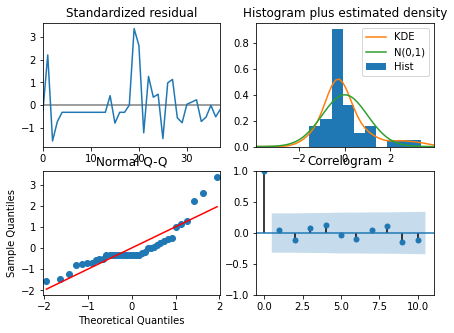

In [ ]:
arima_modal.plot_diagnostics(figsize=(7,5))
plt.show()

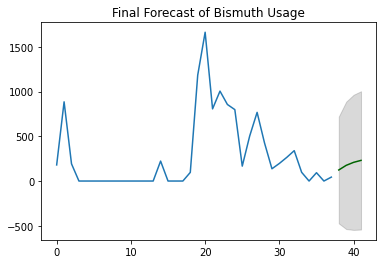

In [ ]:
# Forecast
n_periods = 4
fc, confint = arima_modal.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(yearly_summary_bismuth.values), len(yearly_summary_bismuth.values)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(yearly_summary_bismuth.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Bismuth Usage")
plt.show()

In [ ]:
prediction = pd.DataFrame(arima_modal.predict(n_period=20), columns = ['Predicted Value'])
prediction

,Predicted Value
0,123.429146
1,175.189553
2,208.834768
3,230.704776
4,244.920682
5,254.161282
6,260.167842
7,264.072216
8,266.610131
9,268.259822


# Conclusion

As per the Analysis, the Radon is significantly higher than the required in the water even the forecast says it will increase in the water. Research says Radon can be inhaled from the air or ingested from water. Inhalation of radon increases the chances of lung cancer and this risk is much larger than the risk of stomach cancer from swallowing water with a high radon concentration[3]. 

When bismuth mix with water, it makes the water toxic. According to studies Bismuth + Water
Bismuth reacts with vaporized water and forms trioxide bismuth(III) oxide (Bi2O3). It is important to note that for this reaction to take place, bismuth must be “red hot”, meaning that solid bismuth is so hot that it turns red. Cold, air-free water does not react with bismuth[1].
The permissible limit of Bismuth in water should be  0.3 µg/L but according to analysis, the forecasting quantity of bismuth in water will be significantly higher. The government should take some important actions[2].


**Action needs to be taken:**  To protect the environment from these two chemicals we need to use the Aeration that reduce the mix of harmful chemicals. The best method for removing radon & bismuth from the water is an aeration system. An aeration system is typically installed next to the well tank where your water supply first enters the house. The aeration system is installed after other water conditioners such as a water softener or neutralizer [4].



# References 
1.   https://chemistrytalk.org/serious-bismuth/
2.   https://www.waterquality.gov.au/anz-guidelines/guideline-values/default/water-quality-toxicants/toxicants/bismuth-2000#:~:text=The%20current%20analytical%20practical%20quantitation,water%20(NSW%20EPA%202000).
3.   https://extension.psu.edu/reducing-radon-in-drinking-water
4.   https://wpb-radon.com/radon_in_water_information.html



# Disclaimer  
This analytical research is the result of the analysis carried out by students/research scholars. However, the paper results are approximate and may not be fully accurate. Do not take any decision based on these results. All recommendations are made without guarantee on the part of the author or publisher. The author and publisher disclaim any liability in connection with the use of this information.